In [36]:
import xml.etree.ElementTree as ET
import operator
import logging
from typing import Any, Dict, List, Tuple, TypedDict, Annotated
import pandas as pd
import pygraphviz as pgv
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langgraph.graph import StateGraph
import os

In [37]:
pentaho_file_path = '../data/benef_transf.ktr'

In [38]:
import xml.etree.ElementTree as ET
import operator
import logging
from typing import Any, Dict, List, Tuple, TypedDict, Annotated
import pandas as pd
import pygraphviz as pgv
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langgraph.graph import StateGraph
import os

class SQLAnalysisAgent:
    def __init__(self, llm: Any):
        self.llm = llm

    def analyze(self, queries: List[Dict[str, str]]) -> List[Dict[str, str]]:
        prompt_template = PromptTemplate(
            input_variables=["sql_content"],
            template="""
            Analyze the following SQL query and provide insights on:
            1. The purpose of the query
            2. Tables and columns used
            3. Any joins or complex operations
            4. Potential optimizations
            5. Suggested improvements for a data warehouse setting

            SQL Query:
            {sql_content}

            Provide your analysis in a structured format.
            """
        )

        chain = RunnableSequence(prompt_template, self.llm)
        
        analysis_results = []
        for query in queries:
            response = chain.invoke({"sql_content": query['sql']})
            analysis_results.append({
                "step_name": query['step_name'],
                "analysis": response
            })
        
        return analysis_results

class WorkflowAnalysisAgent:
    def __init__(self, llm: Any):
        self.llm = llm

    def analyze(self, sequence: List[tuple], queries: List[Dict[str, str]], sql_analysis: List[Dict[str, str]]) -> str:
        prompt_template = PromptTemplate(
            input_variables=["sequence", "queries", "sql_analysis"],
            template="""
            Analyze the following workflow and provide insights on:
            1. The overall purpose of the workflow
            2. The sequence of operations
            3. Data flow between steps
            4. Potential bottlenecks or inefficiencies
            5. Suggested improvements for the workflow structure

            Workflow Sequence:
            {sequence}

            Queries:
            {queries}

            SQL Analysis:
            {sql_analysis}

            Provide your analysis in a structured format.
            """
        )

        chain = RunnableSequence(prompt_template, self.llm)
        
        response = chain.invoke({
            "sequence": str(sequence),
            "queries": str(queries),
            "sql_analysis": str(sql_analysis)
        })
        
        return response

class DocumentationAgent:
    def __init__(self, llm: Any):
        self.llm = llm

    def generate(self, workflow_analysis: str, sql_analysis: List[Dict[str, str]]) -> str:
        prompt_template = PromptTemplate(
            input_variables=["workflow_analysis", "sql_analysis"],
            template="""
            Create a comprehensive markdown document that includes:
            1. Executive Summary
            2. Workflow Overview
            3. Detailed Step Analysis
            4. SQL Query Documentation
            5. Identified Issues and Bottlenecks
            6. Recommendations for Improvement

            Use the following information:

            Workflow Analysis:
            {workflow_analysis}

            SQL Analysis:
            {sql_analysis}

            Generate a well-structured markdown document.
            """
        )

        chain = RunnableSequence(prompt_template, self.llm)
        
        response = chain.invoke({
            "workflow_analysis": workflow_analysis,
            "sql_analysis": str(sql_analysis)
        })
        
        return response

class ProjectPlanningAgent:
    def __init__(self, llm: Any):
        self.llm = llm

    def plan(self, documentation: str) -> str:
        prompt_template = PromptTemplate(
            input_variables=["documentation"],
            template="""
            Based on the provided documentation, create a project plan to recreate and improve the workflow:
            1. Identify key objectives for the new project
            2. Outline the main phases of the project
            3. Suggest a new data warehouse structure with dimension and fact tables
            4. Propose improvements for each step of the workflow
            5. Recommend technologies and best practices to be used
            6. Outline a testing and validation strategy

            Documentation:
            {documentation}

            Provide a detailed project plan in markdown format.
            """
        )

        chain = RunnableSequence(prompt_template, self.llm)
        
        response = chain.invoke({"documentation": documentation})
        
        return response

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class AgentState(TypedDict):
    messages: Annotated[list[Any], operator.add]
    root: ET.Element
    sequence: List[Tuple[str, str]]
    queries: List[Dict[str, str]]
    relations: pd.DataFrame
    documentation: str
    sql_analysis: List[Dict[str, str]]
    workflow_analysis: str
    project_plan: str

class Agent:
    def __init__(self, model: Any, tools: Any, file_path: str, system: str = "", max_tokens_per_part: int = 400):
        self.system = system
        self.file_path = file_path
        self.llm = model
        self.max_tokens_per_part = max_tokens_per_part
        
        ktr_filename = os.path.basename(file_path)
        self.markdown_filename = os.path.splitext(ktr_filename)[0] + ".md"
        
        self.sql_analysis_agent = SQLAnalysisAgent(model)
        self.workflow_analysis_agent = WorkflowAnalysisAgent(model)
        self.documentation_agent = DocumentationAgent(model)
        self.project_planning_agent = ProjectPlanningAgent(model)
        
        self.graph = self._create_state_graph()      

    def _create_state_graph(self) -> StateGraph:
        graph = StateGraph(AgentState)

        graph.add_node("parse", lambda state: self.parse_ktr_file(state))
        graph.add_node("extract_sequence", self.extract_execution_sequence)
        graph.add_node("extract_sql", self.extract_sql_queries)
        graph.add_node("save_sql_to_files", self.save_sql_to_files)
        graph.add_node("analyze_sql_files_llm", self.analyze_sql_files_llm)
        graph.add_node("generate_markdown_llm", self.generate_markdown_llm)
        graph.add_node("create_graph", self.create_execution_graph)
        graph.add_node("analyze_sql", self.analyze_sql)
        graph.add_node("analyze_workflow", self.analyze_workflow)
        graph.add_node("generate_documentation", self.generate_documentation)
        graph.add_node("plan_project", self.plan_project)
        graph.add_node("export_markdown", self.export_markdown_to_file)     

        graph.add_edge("parse", "extract_sequence")
        graph.add_edge("extract_sequence", "extract_sql")
        graph.add_edge("extract_sql", "save_sql_to_files")
        graph.add_edge("save_sql_to_files", "analyze_sql_files_llm")
        graph.add_edge("analyze_sql_files_llm", "generate_markdown_llm")
        graph.add_edge("generate_markdown_llm", "create_graph")
        graph.add_edge("create_graph", "export_markdown")

        graph.add_edge("extract_sql", "analyze_sql")
        graph.add_edge("analyze_sql", "analyze_workflow")
        graph.add_edge("analyze_workflow", "generate_documentation")
        graph.add_edge("generate_documentation", "plan_project")
        graph.add_edge("plan_project", "export_markdown")
        

        graph.set_entry_point("parse")
        return graph.compile()
    
    def analyze_sql(self, state: AgentState) -> AgentState:
        state["sql_analysis"] = self.sql_analysis_agent.analyze(state["queries"])
        return state

    def analyze_workflow(self, state: AgentState) -> AgentState:
        state["workflow_analysis"] = self.workflow_analysis_agent.analyze(
            state["sequence"], state["queries"], state["sql_analysis"]
        )
        return state

    def generate_documentation(self, state: AgentState) -> AgentState:
        state["documentation"] = self.documentation_agent.generate(
            state["workflow_analysis"], state["sql_analysis"]
        )
        return state

    def plan_project(self, state: AgentState) -> AgentState:
        state["project_plan"] = self.project_planning_agent.plan(state["documentation"])
        state["documentation"] += "\n\n## Project Plan for Improvement\n\n" + state["project_plan"]
        return state    
    
    def save_sql_to_files(self, state: AgentState) -> AgentState:
        """Save each SQL query to a separate .sql file."""
        os.makedirs('sql_files', exist_ok=True)
        for idx, query in enumerate(state["queries"], start=1):
            file_name = f'sql_files/query_{idx}.sql'
            with open(file_name, 'w') as file:
                file.write(query['sql'])
            query['file_name'] = file_name  # Store the filename for later use

        return state    

    def parse_ktr_file(self, state: AgentState) -> AgentState:
        if "root" not in state or state["root"] is None:
            try:
                tree = ET.parse(self.file_path)
                state["root"] = tree.getroot()
            except ET.ParseError as e:
                logging.error(f"Error parsing KTR file: {e}")
                raise
        return state

    def extract_execution_sequence(self, state: AgentState) -> AgentState:
        hops = []
        for hop in state["root"].findall('.//hop'):
            from_step = hop.find('from').text
            to_step = hop.find('to').text
            enabled = hop.find('enabled').text
            if enabled == 'Y':
                hops.append((from_step, to_step))
        
        state["sequence"] = hops
        return state    

    def extract_sql_queries(self, state: AgentState) -> AgentState:
        active_steps = set(step for seq in state["sequence"] for step in seq)
        sql_steps = state["root"].findall(".//step")
        queries = []
        
        for step in sql_steps:
            step_name = step.find("name").text
            step_type = step.find("type").text
            if step_type in ['TableInput', 'DBJoin'] and step_name in active_steps:
                sql_element = step.find("sql")
                if sql_element is not None and sql_element.text:
                    queries.append({
                        "step_name": step_name,
                        "step_type": step_type,
                        "sql": sql_element.text
                    })
        
        state["queries"] = queries
        return state
    
    def analyze_sql_files_llm(self, state: AgentState) -> AgentState:
        """Analyze the saved SQL files and suggest improvements using an LLM."""
        analysis_results = []
        prompt_template = PromptTemplate(
            input_variables=["sql_content"],
            template="""
            You are an experienced data engineer. Analyze the SQL code below and suggest improvements.
            Consider the structure of fact and dimension tables, indexing, and query performance optimizations.

            SQL Code:
            {sql_content}

            Provide your analysis and suggestions below.
            """
        )

        chain = RunnableSequence(
            prompt_template,
            self.llm
        )

        try:

            for query in state["queries"]:
                file_path = query['file_name']
                with open(file_path, 'r') as file:
                    sql_content = file.read()

                response = chain.invoke({"sql_content": sql_content})
                analysis_results.append({
                    "file_name": file_path,
                    "analysis": response
                })

            state['analysis_results'] = analysis_results

            # Debugging Statement
            logging.debug(f"Analysis Results: {state['analysis_results']}")
        except Exception as e:
            logging.error(f"Error in analyze_sql_files_llm: {e}")
            raise        

        return state  
    
    def generate_markdown_llm(self, state: AgentState) -> AgentState:
        """Generate a Markdown document summarizing the workflow and providing analysis."""
        logging.debug(f"Generating Markdown with the following state: {state}")

        prompt_template = PromptTemplate(
            input_variables=["sequence", "queries", "analysis_results"],
            template="""
            Create a detailed Markdown document that summarizes the workflow. Include the following sections:

            1. **Execution Sequence:** List the order of steps.
            2. **Steps and SQL Files:** Provide a brief description of each step and link to the corresponding .sql file.
            3. **SQL Analysis:** Include the analysis of the SQL files and suggestions for improvement.
            4. **Recommendations:** Based on the analysis, suggest how to restructure the workflow and data warehouse.

            Data:
            Sequence: {sequence}
            Queries: {queries}
            Analysis Results: {analysis_results}
            """
        )

        try:
            chain = RunnableSequence(
                prompt_template,
                self.llm
            )

            sequence_data = "\n".join([f"{idx + 1}. {seq[0]} -> {seq[1]}" for idx, seq in enumerate(state["sequence"])])
            query_data = "\n".join([f"Step: {q['step_name']} - SQL File: {q['file_name']}" for q in state["queries"]])
            analysis_data = "\n".join([f"File: {res['file_name']} - Analysis: {res['analysis']}" for res in state['analysis_results']])

            response = chain.invoke({
                "sequence": sequence_data,
                "queries": query_data,
                "analysis_results": analysis_data
            })

            state["documentation"] = response

            logging.debug(f"Generated Documentation: {state['documentation']}")
        except Exception as e:
            logging.error(f"Error in generate_markdown_llm: {e}")
            raise            

        return state

    def extract_table_column_relations_llm(self, state: AgentState) -> AgentState:
        df = self._extract_table_column_relations_llm(self.llm, state["queries"])
        state["relations"] = df
        return state
          

    def _extract_table_column_relations_llm(self, llm: Any, queries: List[Dict[str, str]]) -> pd.DataFrame:

        def _get_response_text(response: Any) -> str:
            if isinstance(response, str):
                return response
            elif hasattr(response, 'content'):
                return response.content
            elif hasattr(response, 'text'):
                return response.text
            else:
                return ""  

        prompt_template = PromptTemplate(
            input_variables=["sql"],
            template="""
            Analyze the following SQL query and extract all the table/column relationships, ensuring that the original table names are captured, even if aliases (nicknames) are used:
            {sql}
            Return a list of table/column pairs in the format:
            original_table_name,column_name
            original_table_name,column_name
            ...
            Do not include any additional text in your response, only the list of pairs.
            """
        )

        chain = RunnableSequence(
            prompt_template,
            llm
        )

        results = []

        for query in queries:
            sql_code = query['sql']
            sql_parts = self._split_sql_code(sql_code)

            for sql_part in sql_parts:
                try:
                    response = chain.invoke({"sql": sql_part})
                    response_text = _get_response_text(response)
                    lines = response_text.strip().split('\n')

                    for line in lines:
                        if ',' in line:
                            parts = line.split(',')
                            if len(parts) == 2:
                                table, column = parts
                                results.append({'nome_tabela': table.strip(), 'nome_coluna': column.strip()})
                            else:
                                logging.warning(f"Unexpected format: {line}")
                except Exception as e:
                    logging.error(f"Error processing SQL part: {e}")

        df = pd.DataFrame(results).drop_duplicates()
        return df
    
    def export_markdown_to_file(self, state: AgentState) -> AgentState:
        try:
            with open(self.markdown_filename, 'w', encoding='utf-8') as f:
                f.write(state["documentation"])
            logging.info(f"Markdown documentation exported to {self.markdown_filename}")
        except Exception as e:
            logging.error(f"Error exporting markdown to file: {e}")
            raise
        return state 

    def _split_sql_code(self, sql_code: str) -> List[str]:
        sql_lines = sql_code.split('\n')
        parts = []
        current_part = []
        current_length = 0

        for line in sql_lines:
            line_length = len(line.split())
            if current_length + line_length > self.max_tokens_per_part:
                parts.append('\n'.join(current_part))
                current_part = [line]
                current_length = line_length
            else:
                current_part.append(line)
                current_length += line_length

        if current_part:
            parts.append('\n'.join(current_part))

        return parts

    def create_documentation(self, state: AgentState) -> AgentState:
        """Creates Markdown documentation summarizing the KTR pipeline."""
        doc_lines = ["# Pipeline Documentation\n"]

        doc_lines.append("## Execution Sequence\n")
        for idx, (from_step, to_step) in enumerate(state["sequence"], start=1):
            doc_lines.append(f"{idx}. {from_step} -> {to_step}\n")

        doc_lines.append("## Steps and SQL Summaries\n")
        for query in state["queries"]:
            doc_lines.append(f"### Step: {query['step_name']}\n")
            doc_lines.append(f"- Type: {query['step_type']}\n")
            doc_lines.append("#### SQL Summary:\n")
            doc_lines.append(f"```sql\n{query['sql'][:200]}...\n```\n")

        doc_lines.append("## Table/Column Relationships\n")
        for _, row in state["relations"].iterrows():
            doc_lines.append(f"- {row['nome_tabela']} -> {row['nome_coluna']}\n")

        state["documentation"] = "\n".join(doc_lines)
        return state

    def create_execution_graph(self, state: AgentState) -> AgentState:
        self.create_flow_graph(state["sequence"])
        return state

    def create_flow_graph(self, hops: List[Tuple[str, str]], output_file: str = "flow_graph.png"):
        graph = pgv.AGraph(directed=True)
        
        for from_step, to_step in hops:
            graph.add_node(from_step, shape="box")
            graph.add_node(to_step, shape="box")
            graph.add_edge(from_step, to_step)
        
        graph.layout(prog='dot')
        graph.draw(output_file)
        logging.info(f"Data flow saved in {output_file}")

    def run(self) -> AgentState:
        initial_state = AgentState(
            messages=[],
            root=None,
            sequence=[],
            queries=[],
            relations=pd.DataFrame(),
            documentation="",
            sql_analysis=[],
            workflow_analysis="",
            project_plan=""
        )
        try:
            final_state = self.graph.invoke(initial_state)
            return final_state
        except Exception as e:
            logging.error(f"Error running agent pipeline: {e}")
            raise

In [39]:
model = OllamaLLM(model='qwen2:latest', temperature=0.0)

In [40]:
# model = ChatGoogleGenerativeAI(
#     model='gemini-1.5-pro-exp-0801',
#     temperature=0
# )

In [41]:
tool = []

In [42]:
prompt = ""

In [43]:
abot = Agent(model=model, file_path=pentaho_file_path)

TypeError: Agent.__init__() missing 1 required positional argument: 'tools'

In [52]:
final_state = abot.run()

2024-08-24 14:58:55,776 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:00:10,887 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:01:26,482 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:02:47,838 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:04:20,847 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:05:57,428 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2024-08-24 15:07:03,379 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


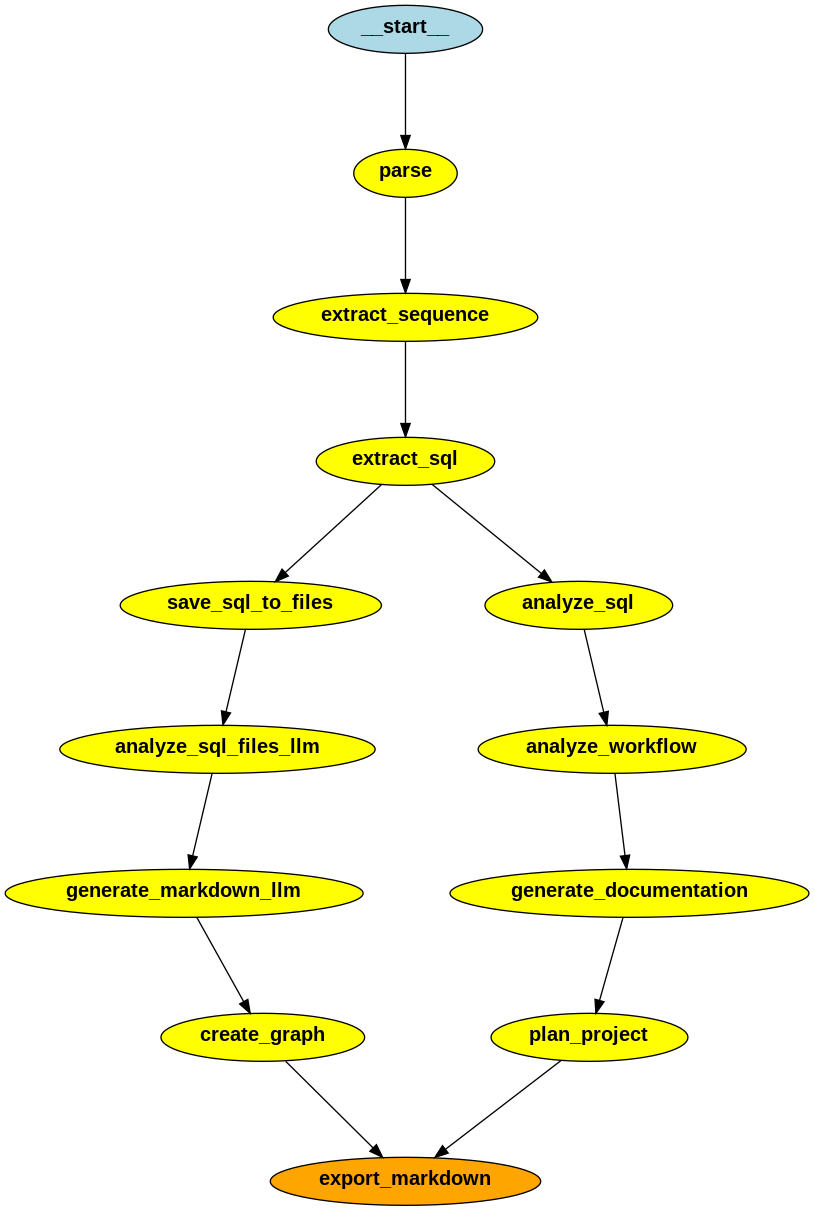

In [14]:
from IPython.display import Image
Image(abot.graph.get_graph().draw_png())